# Table of Contents
1.   Importing Libraries
2.   Importing Data
3.   XGBoost Model
4.   Tuning Hyperprmeters
5.   Error Analysis







In [15]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from typing import List, Union, Dict, Set, Tuple
import numpy as np
from numpy.typing import NDArray


from collections import defaultdict, Counter
from typing import Dict
from nltk.corpus import gutenberg
from typing import Union, List
import string

import nltk
from nltk.corpus.reader.util import StreamBackedCorpusView
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier


import xgboost as xgb

import seaborn as sns
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


word_vectors = {}
with open('/content/drive/MyDrive/Colab Notebooks/MannheimWMProject/Glove/glove.6B.300d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:],'float32')
    word_vectors[word]=vectors


import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/MannheimWMProject/')
import preprocessing
!pip install emoji
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MannheimWMProject/airlines_reviews.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing

In [18]:
grouped = df.groupby(['Recommended', 'Overall Rating']).size().reset_index(name='count')
pivot_matrix = grouped.pivot_table(index='Recommended', columns='Overall Rating', values='count', fill_value=0)
pivot_matrix

Overall Rating,1,2,3,4,5,6,7,8,9,10
Recommended,,,,,,,,,,
no,1791,669,488,330,305,123,54,14,19,20
yes,17,23,34,51,131,223,455,728,1035,1590


In this case, Rating=1-4 -> not recommended; Rating=5-6 -> neural; Rating=7-10 -> recommended;
Only take Rating=1-4 -> not recommended, Rating=7-10 -> recommended train sentimental analysis model.


In [19]:
#Create new function to convert Rating scores to 3 categories
#1-4, 5-6, 7-10 forms negative, neutral, positive [-1,0,1]
def score_convert_senti(score):
    if score <= 4:
        return -1
    elif score >= 5 and score <= 6:
        return 0
    elif score >= 7:
        return 1

#Create new column, convert scoring into 3 categories
df["Sentiment"] = df["Overall Rating"].apply(score_convert_senti)
df_filtered= df[((df["Sentiment"]==1) & (df["Recommended"]=='yes')) | ((df["Sentiment"]==-1) & (df["Recommended"]=='no'))]
df_filtered.head()
df_filtered.groupby(['Recommended', 'Sentiment']).size()

Recommended  Sentiment
no           -1           3278
yes           1           3808
dtype: int64

In [24]:

def text_to_vector(text):
    # text_preprocessed=preprocessing.preprocess_reviews(text)
    words = text.split()
    vectors = [word_vectors[word] for word in words if word in word_vectors]
    if len(vectors) > 0:
        max_length = max(len(vector) for vector in vectors)
        padded_vectors = [np.pad(vector, (0, max_length - len(vector)), mode='constant') for vector in vectors]
        return np.mean(np.vstack(padded_vectors), axis=0)
    else:
        return np.zeros(vector_size)


In [34]:
X = df['Reviews']
y = df['Sentiment']
X_preprocessed=preprocessing.preprocess_reviews(X)
X_preprocessed= X_preprocessed.apply(text_to_vector)
X = np.vstack(X_preprocessed)
print(X)

[[ 0.12555505 -0.0355822  -0.00940979 ... -0.04494987 -0.07985108
  -0.00506728]
 [-0.10284501 -0.09145565  0.11728562 ... -0.15694857  0.03389191
   0.00187407]
 [ 0.01626334  0.16090053 -0.12170778 ... -0.2869282  -0.08130356
  -0.30545443]
 ...
 [-0.08672043  0.13437529 -0.08863271 ... -0.21265703 -0.06292971
  -0.05155307]
 [-0.0415783   0.05050199  0.06310954 ... -0.12161891 -0.08390979
  -0.03628812]
 [ 0.05296925  0.14066587 -0.04025602 ... -0.08066425  0.01383654
  -0.12126777]]


GD

In [33]:
# baseline, without tuning hp

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost with the encoded labels
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_train, y_train_encoded)
y_pred_encoded = xgb_classifier.predict(X_test)

# Convert predictions back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print("Accuracy:", accuracy)
F1_weighted = f1_score(y_test_encoded, y_pred_encoded, average="weighted")
print("Weighted F1 Score:", F1_weighted)
F1 = f1_score(y_test_encoded, y_pred_encoded, average=None)
print("F1 Score:", F1)


Accuracy: 0.7851851851851852
Weighted F1 Score: 0.7450407250758745
F1 Score: [0.81465201 0.         0.83889865]


Hyperparameter Tuning

In [ ]:

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_val_encoded = label_encoder.fit_transform(y_train_val)
y_test_encoded = label_encoder.transform(y_test)


param_grid = {
    'max_depth': [2,5,8],
    # 'min_child_weight': [8, 10, 12],
    'gamma': [0.3,0.6,0.8],
    # 'subsample': [0.6, 0.8, 1.0],
    # 'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.1,0.2,0.3]
}


grid_search = GridSearchCV(xgb.XGBClassifier(use_label_encoder=True), param_grid, cv=2, scoring='f1_weighted')
grid_search.fit(X_train_val, y_train_val_encoded)

best_model = grid_search.best_estimator_

y_pred_encoded = xgb_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
f1 = f1_score(y_test_encoded, y_pred_encoded, average="weighted")

print("Best parameters:", grid_search.best_params_)
print("Test Accuracy:", test_accuracy)
print("F1 Score:", f1)


Best parameters: {'gamma': 0.6, 'learning_rate': 0.2, 'max_depth': 5}
Test Accuracy: 0.8206172839506173
F1 Score: 0.7828290249762543


Error Analysis

Accuracy: 0.8030864197530864
Weighted F1 Score: [0.83477011 0.05434783 0.859375  ]
Weighted F1 Score: 0.7687569409739575
Confusion Matrix:
[[581  10  75]
 [ 75   5  82]
 [ 70   7 715]]


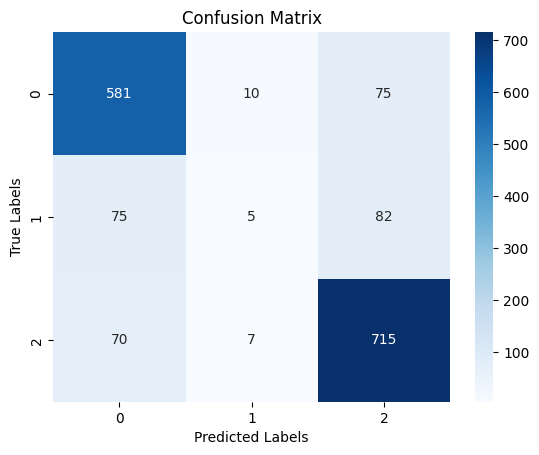

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost with the encoded labels
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',gamma=0.6,learning_rate=0.2,max_depth=5)
xgb_classifier.fit(X_train, y_train_encoded)
y_pred_encoded = xgb_classifier.predict(X_test)

# Convert predictions back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print("Accuracy:", accuracy)
F1 = f1_score(y_test_encoded, y_pred_encoded, average=None)
F11 = f1_score(y_test_encoded, y_pred_encoded, average="weighted")
print("Weighted F1 Score:", F1)
print("Weighted F1 Score:", F11)
cm = confusion_matrix(y_test_encoded, y_pred_encoded)


print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test = np.array(y_test)
y_pred = np.array(y_pred)

indices_y_test_0 = np.where(y_test == 0)[0]

misclassified_indices = indices_y_test_0[y_test[indices_y_test_0] != y_pred[indices_y_test_0]]

misclassified_samples = X_test[misclassified_indices]
misclassified_true_labels = y_test[misclassified_indices]
misclassified_predicted_labels = y_pred[misclassified_indices]
misclassified_reviews = df['Reviews'].iloc[misclassified_indices]

output_df = pd.DataFrame({
    'sample_index': misclassified_indices,
    'review': misclassified_reviews,
    'true_label': misclassified_true_labels,
    'predicted_label': misclassified_predicted_labels
})

output_df.to_csv('misclassified_samples.csv', index=False)


In [ ]:
mis_neutral=pd.read_csv('misclassified_samples.csv')
print(mis_neutral["review"][1])

 This was my first time flying on a regional Singapore Airlines flight on a narrow-bodied aircraft since the old subsidiary Silk Air was absorbed by the parent carrier, and I was impressed. Everything went well on the flight, from boarding, to exemplary behaviour and courtesy shown by the cabin crew, to the food and boarding process at Changi airport. The inflight entertainment provided was the full product used for their long haul flights — amazing!


Accuracy: 0.7604938271604939
Weighted F1 Score: [0.80059303 0.20945946 0.82884013]
Weighted F1 Score: 0.7552893647974296
Confusion Matrix:
[[540  46  80]
 [ 69  31  62]
 [ 74  57 661]]


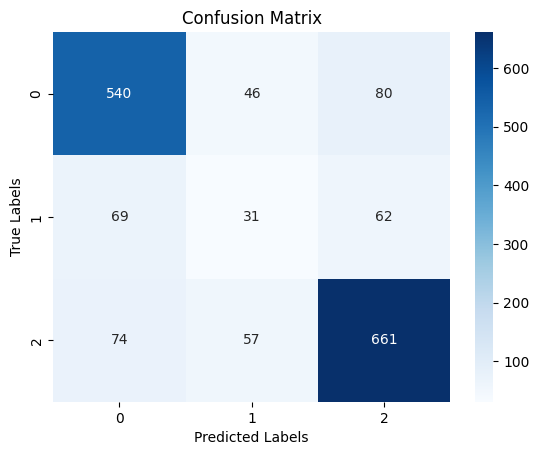

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
# Initialize label encoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost with the encoded labels
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',gamma=0.6,learning_rate=0.2,max_depth=5)
xgb_classifier.fit(X_train, y_train_encoded)
y_pred_encoded = xgb_classifier.predict(X_test)

# Convert predictions back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print("Accuracy:", accuracy)
F1 = f1_score(y_test_encoded, y_pred_encoded, average=None)
F11 = f1_score(y_test_encoded, y_pred_encoded, average="weighted")
print("Weighted F1 Score:", F1)
print("Weighted F1 Score:", F11)
cm = confusion_matrix(y_test_encoded, y_pred_encoded)

print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**additional part, doesn't influence final results**


tune hp manually, print results by lines


In [ ]:

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

param_grid = {
    'n_estimators': [200],
    'learning_rate': [1],
    'max_depth': [3, 10, 30, 50],
    # 'subsample': [0.5, 0.8,1]
}

# hp tuning manualy
best_params = None
best_accuracy = 0

for params in ParameterGrid(param_grid):
    model = GradientBoostingClassifier(**params)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)

    print("Params:", params)
    print("Validation Accuracy:", accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

best_model = GradientBoostingClassifier(**best_params)
best_model.fit(X_train_val, y_train_val)
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print("Best parameters:", best_params)
print("Test Accuracy:", test_accuracy)
print("F1 Score:", f1)




Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.5}
Validation Accuracy: 0.7839506172839507
Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Validation Accuracy: 0.7932098765432098
Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.5}
Validation Accuracy: 0.7808641975308642
Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
Validation Accuracy: 0.7790123456790123
Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.5}
Validation Accuracy: 0.7820987654320988
Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
Va